In [197]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from statsmodels.tsa.stattools import adfuller

warnings = warnings.filterwarnings('ignore')

df=pd.read_csv('stock_details_5_years.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-29 00:00:00-05:00,43.829761,43.863354,42.639594,43.083508,167080000,0.00,0.0,AAPL
1,2018-11-29 00:00:00-05:00,104.769074,105.519257,103.534595,104.636131,28123200,0.00,0.0,MSFT
2,2018-11-29 00:00:00-05:00,54.176498,55.007500,54.099998,54.729000,31004000,0.00,0.0,GOOGL
3,2018-11-29 00:00:00-05:00,83.749496,84.499496,82.616501,83.678497,132264000,0.00,0.0,AMZN
4,2018-11-29 00:00:00-05:00,39.692784,40.064904,38.735195,39.037853,54917200,0.04,0.0,NVDA


In [198]:
required_length = 1258

df_filtered_stocks = df.dropna(axis=1, thresh=required_length)

if df_filtered_stocks.empty:
    raise ValueError("No columns left with the required non-NaN entry count.")

df_filtered_stocks = df_filtered_stocks.loc[:, df_filtered_stocks.isnull().sum() == 0]

if df_filtered_stocks.empty:
    raise ValueError("No columns left after removing columns with any NaN values.")

In [199]:
missing_values = df_filtered_stocks.isnull().sum()
missing_values[missing_values > 0]

Series([], dtype: int64)

In [200]:
df_filtered_stocks.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-29 00:00:00-05:00,43.829761,43.863354,42.639594,43.083508,167080000,0.00,0.0,AAPL
1,2018-11-29 00:00:00-05:00,104.769074,105.519257,103.534595,104.636131,28123200,0.00,0.0,MSFT
2,2018-11-29 00:00:00-05:00,54.176498,55.007500,54.099998,54.729000,31004000,0.00,0.0,GOOGL
3,2018-11-29 00:00:00-05:00,83.749496,84.499496,82.616501,83.678497,132264000,0.00,0.0,AMZN
4,2018-11-29 00:00:00-05:00,39.692784,40.064904,38.735195,39.037853,54917200,0.04,0.0,NVDA


In [201]:
# Lets create some more features before transforming into tensors, we will create the following features: volume weighted closing prices, moving averages, returns, risk, volatility, and momentum.

# Volume weighted closing prices
df_filtered_stocks['Volume_weighted_price'] = df_filtered_stocks['Close'].mul(df_filtered_stocks['Volume']).sum() / df_filtered_stocks['Volume'].sum()

# Moving averages
df_filtered_stocks['MA_10'] = df_filtered_stocks['Close'].rolling(window=10).mean()

# Returns
df_filtered_stocks['Returns'] = df_filtered_stocks['Close'].pct_change()

# Risk
df_filtered_stocks['Risk'] = df_filtered_stocks['Returns'].rolling(window=10).std()

# Volatility
df_filtered_stocks['Volatility'] = df_filtered_stocks['Returns'].rolling(window=10).std().mul(np.sqrt(252))

# Momentum
df_filtered_stocks['Momentum'] = df_filtered_stocks['Close'].pct_change(10)

# Drop the first 10 rows as they contain NaN values
df_filtered_stocks = df_filtered_stocks[10:]

# Removing open, high, low, dividends, stock splits.
df_filtered_stocks.drop(['Open', 'High', 'Low', 'Dividends', 'Stock Splits'], axis=1, inplace=True)

df_filtered_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602952 entries, 10 to 602961
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Date                   602952 non-null  object 
 1   Close                  602952 non-null  float64
 2   Volume                 602952 non-null  int64  
 3   Company                602952 non-null  object 
 4   Volume_weighted_price  602952 non-null  float64
 5   MA_10                  602952 non-null  float64
 6   Returns                602952 non-null  float64
 7   Risk                   602952 non-null  float64
 8   Volatility             602952 non-null  float64
 9   Momentum               602952 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 46.0+ MB


In [205]:
# Now we transform the data into a tensor format so we can represent the data as sequence, tickers, and features. 

df_filtered_stocks.sort_values(['Company', 'Date'], inplace=True)

df_pivot = df_filtered_stocks.pivot(index = 'Date', columns = 'Company')

tensor = df_pivot.to_numpy().reshape(df_pivot.shape[0], df_pivot.shape[1] // len(df_filtered_stocks['Company'].unique()), len(df_filtered_stocks['Company'].unique()))

import torch

tensor = torch.from_numpy(tensor)

In [206]:
tensor.shape

torch.Size([1258, 8, 491])

In [207]:
# Now we will split the data into training and testing sets. We will use the first 80% of the data for training and the remaining 20% for testing.

train_size = int(tensor.size(0) * 0.8)

train_data = tensor[:train_size]
test_data = tensor[train_size:]

# Now we will normalize the data using the min-max normalization technique.

train_max = train_data.max()
train_min = train_data.min()

train_data = (train_data - train_min) / (train_max - train_min)
test_data = (test_data - train_min) / (train_max - train_min)

# Now we will create a function to generate the input and target sequences for the model.

def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data) - seq_length - 1):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x.view(x.shape[0], -1))  # Reshape x
        ys.append(y.view(-1))  # Reshape y

    return torch.stack(xs), torch.stack(ys)

seq_length = 10

x_train, y_train = create_sequences(train_data, seq_length)
x_test, y_test = create_sequences(test_data, seq_length)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([995, 10, 3928]),
 torch.Size([995, 3928]),
 torch.Size([241, 10, 3928]),
 torch.Size([241, 3928]))

In [208]:
print(torch.isnan(x_train).any(), torch.isinf(x_train).any())
print(torch.isnan(y_train).any(), torch.isinf(y_train).any())

# Since we have NaN values in x_train and y_train, we will replace them with 0.

x_train[torch.isnan(x_train)] = 0
y_train[torch.isnan(y_train)] = 0

tensor(True) tensor(False)
tensor(True) tensor(False)


In [209]:
import torch
import torch.nn as nn
import torch.optim as optim

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # Output size matches the flattened feature size

    def forward(self, x):
        # Initial hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Since you've flattened the features and company tickers, input and output sizes are 3928
input_size = 3928
hidden_size = 128  # Hidden layer size
num_layers = 1  # Number of RNN layers
output_size = 3928  # Predicting the same number of features as input

model = Model(input_size, hidden_size, num_layers, output_size)


import torch.optim as optim

# Assuming x_train and y_train are already defined and loaded correctly

criterion = nn.MSELoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Optimizer with adjusted learning rate

num_epochs = 100  # Number of epochs to train for

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode (important for models with dropout, batchnorm etc.)
    
    outputs = model(x_train.float())  # Corrected to use the model instance
    loss = criterion(outputs, y_train.float())

    optimizer.zero_grad()  # Clear gradients before backward pass
    loss.backward()  # Backpropagation
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
    
    optimizer.step()  # Update model parameters

    if (epoch + 1) % 10 == 0:  # Print loss every 10 epochs
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')

Epoch [10/100], Loss: 0.00048763660015538335
Epoch [20/100], Loss: 7.490192365366966e-05
Epoch [30/100], Loss: 2.5539247872075066e-05
Epoch [40/100], Loss: 8.898864507500548e-06
Epoch [50/100], Loss: 3.193410748281167e-06
Epoch [60/100], Loss: 1.1363520115992287e-06
Epoch [70/100], Loss: 4.10761259672654e-07
Epoch [80/100], Loss: 1.473257214001933e-07
Epoch [90/100], Loss: 5.233674116311704e-08
Epoch [100/100], Loss: 1.879015343320134e-08


In [211]:
# Now we will test the model using the testing data.

model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    y_test_pred = model(x_test.float())
    
    test_loss = criterion(y_test_pred, y_test.float())
    print(f'Test loss: {test_loss.item()}')

# Now we will plot the predicted values against the actual values.
    
plt.figure(figsize=(12, 6))

plt.plot(y_test[:1000], label='Actual')
plt.plot(y_test_pred[:1000], label='Predicted')

plt.title('Actual vs Predicted')
plt.legend()
plt.show()

Test loss: nan


ValueError: Image size of 1002x164590 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1200x600 with 1 Axes>

In [7]:
# https://link.springer.com/article/10.1007/s12572-021-00299-5

def fractional_difference(series, d, threshold=1e-5):
    """
    Computes the fractionally differenced series using a fast algorithm.
    The threshold determines the cut-off weight for the weights vector.
    """
    # Initialization
    weights = [1]
    k = 1
    while True:
        weight = -weights[-1] * (d - k + 1) / k
        if abs(weight) < threshold:
            break
        weights.append(weight)
        k += 1

    weights = np.array(weights[::-1])
    diff_series = np.convolve(series, weights, mode='full')[:len(series)]
    diff_series[:len(weights)] = np.nan  # due to the lag from convolution, set the first few values to nan
    return diff_series

In [8]:
cumsum_df = df_filtered_stocks.cumsum()

min_d_values = {}
p_values = {}

def find_min_d(series, d_start, d_end, d_increment, p_value_threshold=0.05):
    """
    Applies the ADF test to fractionally differenced series for a range of d values.
    Returns the minimum d that leads to a p-value below the threshold.
    Adjusts max_lags based on series length to avoid NameError.
    """
    min_p_value = 1.0
    min_d = None
    for d in np.arange(d_start, d_end, d_increment):
        # Fractionally difference the series
        fd_series = fractional_difference(series, d)
        
        # Drop NaN values generated by differencing
        fd_series = fd_series[~np.isnan(fd_series)]
        
        # Check if the series is empty after removing NaNs
        if fd_series.size == 0:
            continue  # Skip this iteration if fd_series is empty
        
        ntrend = 1  # Assuming a constant in the regression
        max_allowed_lag = max(0, (len(fd_series) // 2 - ntrend - 1))
        
        # Dynamically determine max_lags within bounds
        dynamic_max_lags = min(20, max_allowed_lag)  # 20 is chosen arbitrarily, adjust as needed

        # Apply the ADF test with a suitable max_lag
        p_value = adfuller(fd_series, maxlag=dynamic_max_lags, autolag='AIC')[1]
        
        if p_value < min_p_value:
            min_p_value = p_value
            min_d = d
        
        if p_value < p_value_threshold:
            return d, p_value
    
    return min_d, min_p_value  # Return the best found, even if not under the threshold

# Iterating over each stock with corrected function call
min_d_values = {}
p_values = {}

for stock in cumsum_df.columns:
    series = cumsum_df[stock].values
    
    # Ensure the series is not empty
    if len(series) == 0:
        continue

    min_d, p_value = find_min_d(series, d_start=0, d_end=1, d_increment=0.01, p_value_threshold=0.05)
    
    if min_d is not None:
        min_d_values[stock] = min_d
        p_values[stock] = p_value
        # Apply fractional differencing with the found min_d
        fd_series = fractional_difference(series, min_d)
        # Storing the fractionally differenced series
        df_filtered_stocks[f'FD_{stock}'] = fd_series
    else:
        print(f"Could not find a suitable d value for stock {stock} that satisfies the ADF p-value criterion.")

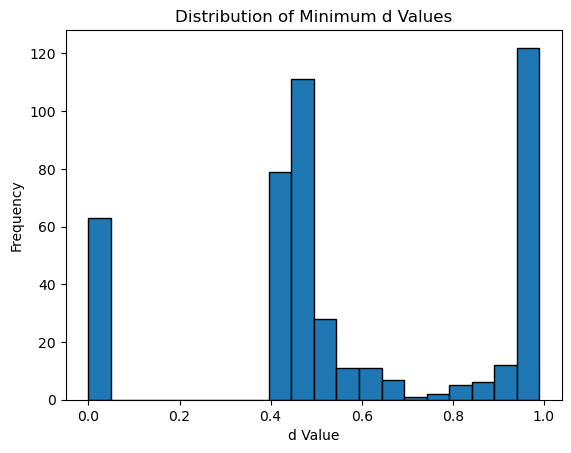

In [9]:
import matplotlib.pyplot as plt

# Assuming min_d_values is a dictionary with stocks as keys and their respective min d values as values
d_values = list(min_d_values.values())

plt.hist(d_values, bins=20, edgecolor='black')
plt.title('Distribution of Minimum d Values')
plt.xlabel('d Value')
plt.ylabel('Frequency')
plt.show()


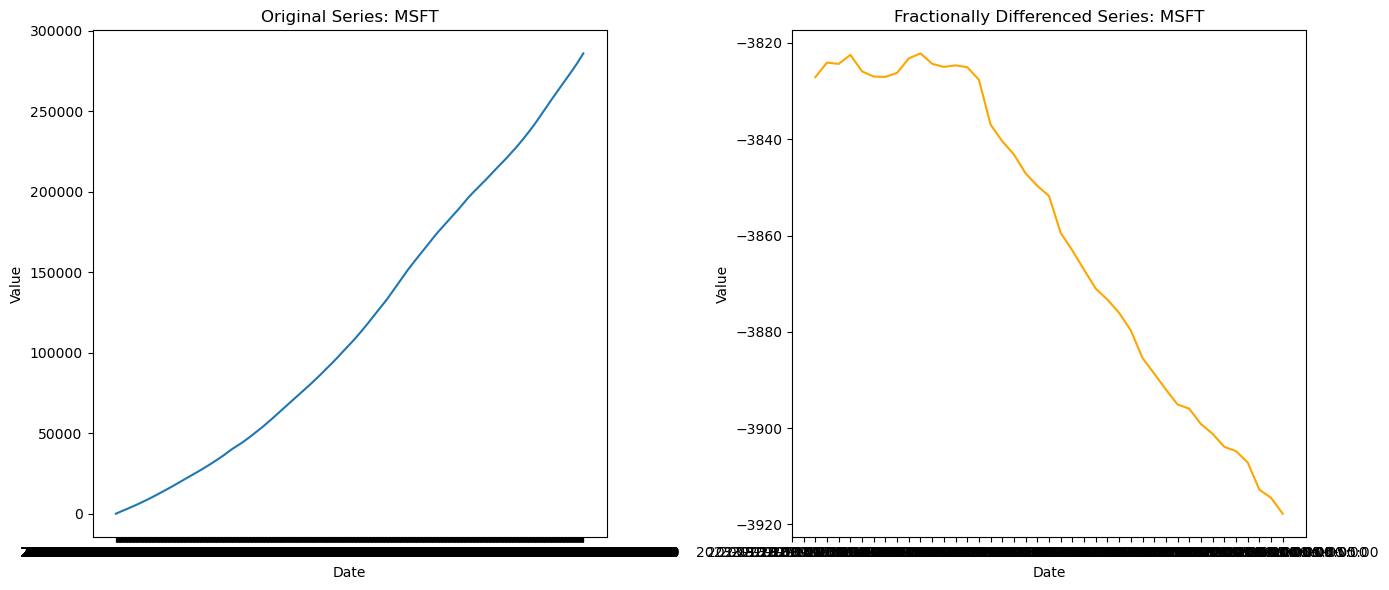

In [10]:
# Example: Plot original and fractionally differenced series for a specific stock
stock_example = 'MSFT'

original_series = cumsum_df[stock_example]
fd_series = df_filtered_stocks[f'FD_{stock_example}']

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(original_series, label='Original')
plt.title(f'Original Series: {stock_example}')
plt.xlabel('Date')
plt.ylabel('Value')

plt.subplot(1, 2, 2)
plt.plot(fd_series, label='Fractionally Differenced', color='orange')
plt.title(f'Fractionally Differenced Series: {stock_example}')
plt.xlabel('Date')
plt.ylabel('Value')

plt.tight_layout()
plt.show()


In [ ]:
# Sources

# https://karpathy.github.io/2015/05/21/rnn-effectiveness/
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html
# https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
# https://karpathy.github.io/2019/04/25/recipe/

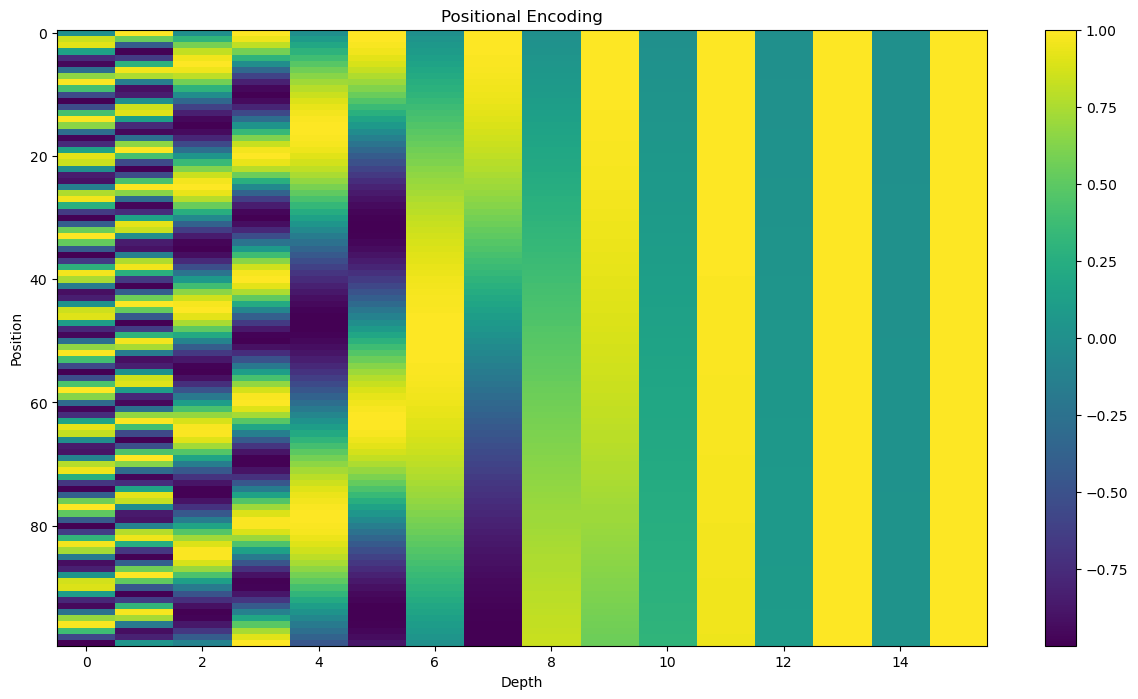

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def positional_encoding(positions, d_model):
    """
    Generate positional encoding for a given number of positions and model dimension.
    
    Parameters:
    - positions: int, the number of positions.
    - d_model: int, the dimensionality of the model/embeddings.
    
    Returns:
    - A numpy array of shape (positions, d_model) containing the positional encodings.
    """
    # Initialize the positional encoding matrix
    pos_enc = np.zeros((positions, d_model))
    # Compute the positions and dimensions as per the formula
    position = np.arange(positions)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    
    # Apply the sine to even indices and cosine to odd indices
    pos_enc[:, 0::2] = np.sin(position * div_term)
    pos_enc[:, 1::2] = np.cos(position * div_term)
    
    return pos_enc

# Parameters
positions = 100  # Number of positions to generate
d_model = 16     # Dimensionality of the model

# Generate positional encoding
pos_encoding = positional_encoding(positions, d_model)

# Plotting
plt.figure(figsize=(15, 8))
plt.imshow(pos_encoding, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Positional Encoding')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.show()
